<a href="https://colab.research.google.com/github/Ramkanc/Capstone_IIITH/blob/Capstone1_MultiModel_V1/Capstone1_RamK_Multi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install opencv-python==4.8.0.76

In [1]:
# Import Libraries
import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F

from torchsummary import summary
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.datasets import ImageFolder

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir
import pandas as pd

In [2]:
import PIL
from PIL import Image

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1


In [4]:
found_directories = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
found_files =[f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
print (found_directories)
print (found_files)

['Images']
['captions.txt']


In [5]:
image_dir= os.path.join(path, found_directories[0])
print(image_dir)

/root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1/Images


In [6]:
# Define a custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, image_dir):
        """
        Args:
            image_dir (str): Path to the directory with images.
        """
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('jpg', 'png', 'jpeg'))]

    def preprocess_image_opencv(self, image_path):
        # Read the image using OpenCV
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Image not found at {image_path}")

        # Resize to 224x224
        image_resized = cv2.resize(image, (224, 224))

        # Convert from BGR to RGB
        image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)

        # Normalize pixel values to [0, 1]
        image_normalized = image_rgb / 255.0

        # Reshape to CxHxW
        image_reshaped = np.transpose(image_normalized, (2, 0, 1))

        # Convert to PyTorch tensor
        image_tensor = torch.tensor(image_reshaped, dtype=torch.float32)

        # Normalize using ImageNet mean and std
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        image_tensor = (image_tensor - mean) / std

        return image_tensor

    def __len__(self):
        # Return the number of images
        return len(self.image_files)

    def __getitem__(self, idx):
        # Get the image path
        image_file_name = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_file_name)

        # Preprocess the image
        image_tensor = self.preprocess_image_opencv(image_path)

        # Extract image ID (filename without extension)
        image_id = os.path.splitext(image_file_name)[0]

        # Return the processed tensor
        return image_tensor,image_id

In [7]:
# Create an instance of the custom dataset
dataset = CustomImageDataset(image_dir)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [10]:
# Iterate over the DataLoader
for batch_idx, (batch_images, image_ids) in enumerate(dataloader):
    print(f"Batch {batch_idx + 1}:")
    print(f"Shape: {batch_images.shape}")  # Expected: [batch_size, 3, 224, 224]
    print(f"Type: {batch_images.dtype}")  # Expected: torch.float32
    print(f"Image IDs: {image_ids}")  # Print the image IDs in the batch
    break

Batch 1:
Shape: torch.Size([32, 3, 224, 224])
Type: torch.float32
Image IDs: ('1562478333_43d13e5427', '140377584_12bdbdf2f8', '2148013097_6a4f495bc5', '3534952095_975cca0056', '3561314880_ea9a7e245f', '470903027_489cc507de', '964197865_0133acaeb4', '3203872773_6c30f64be3', '392467282_00bb22e201', '95151149_5ca6747df6', '262446581_06ef7d9445', '895502702_5170ada2ee', '3017220118_6a9212dfdb', '2181846120_3744ca3942', '2275253272_00f941366e', '3115901702_f07aa0ef74', '3319388517_5609ae9805', '2656039837_f46b29af92', '3697456750_460aea7252', '459284240_5a4167bf92', '3195040792_a03954a19f', '2470519275_65725fd38d', '3404552106_f516df0f5b', '397982550_cf9f5cdb74', '3358380484_b99b48f0c9', '2256133102_e2c8314ecb', '107582366_d86f2d3347', '247706586_7e25c7adf8', '318667317_108c402140', '441817653_fbdf83060b', '3147217787_ed21cd4990', '444481722_690d0cadcf')


In [11]:
# Function to display a single image
def show_image(image_tensor):
    # Undo normalization for display (optional if you want raw pixel values)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image_tensor = image_tensor * std + mean  # Denormalize

    # Convert from Tensor (CxHxW) to NumPy array (HxWxC)
    image_numpy = image_tensor.permute(1, 2, 0).numpy()
    image_numpy = np.clip(image_numpy, 0, 1)  # Clip values to [0, 1] for proper display

    # Display the image
    plt.imshow(image_numpy)
    plt.axis('off')

In [14]:
def display_images_from_dataloader(dataloader, num_images=10):
    images_shown = 0
    plt.figure(figsize=(15, 10))  # Adjust figure size for better visualization

    for batch_idx, (batch_images, image_ids) in enumerate(dataloader):
        for image_idx, image_tensor in enumerate(batch_images):
            if images_shown >= num_images:
                break

            # Get the image ID for the current image
            image_id = image_ids[image_idx]

            plt.subplot(2, 5, images_shown + 1)  # Create a 2x5 grid for 10 images
            show_image(image_tensor)
            plt.title(image_id)  # Set the image ID as the title
            images_shown += 1

        if images_shown >= num_images:
            break

    plt.tight_layout()
    plt.show()

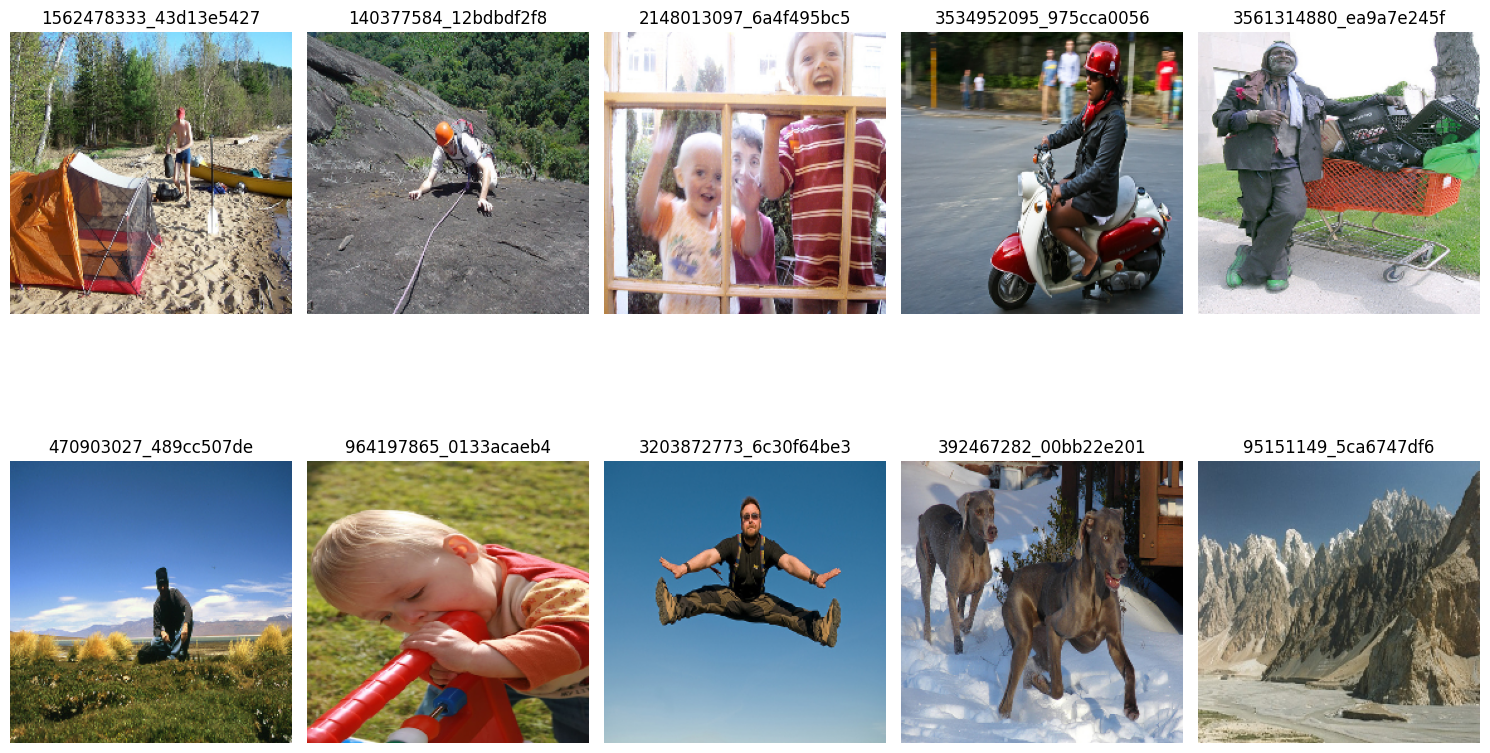

In [15]:
# Call the function to display images
display_images_from_dataloader(dataloader,num_images=10)

In [54]:
labels_file = os.path.join(path, found_files[0])

In [55]:
# for line in open(labels_file, 'r'):
#     print(line)

In [56]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.max_colwidth', None) # Show full column width

In [57]:
raw_captions = pd.read_csv(labels_file, delimiter=',',header=0)

In [58]:
raw_captions.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .


In [59]:
concatenated_df= raw_captions.groupby('image')['caption'].apply(lambda x: ' '.join(x.astype(str))).reset_index()

In [60]:
concatenated_df.head(2)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way . A girl going into a wooden building . A little girl climbing into a wooden playhouse . A little girl climbing the stairs to her playhouse . A little girl in a pink dress going into a wooden cabin .
1,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting A black dog and a tri-colored dog playing with each other on the road . A black dog and a white dog with brown spots are staring at each other in the street . Two dogs of different breeds looking at each other on the road . Two dogs on pavement moving toward each other .


In [61]:
concatenated_df['caption_word_count'] = concatenated_df['caption'].apply(lambda x: len(x.split()))

In [62]:
concatenated_df['image'] = concatenated_df['image'].str.replace('.jpg', '', regex=False)

In [63]:
concatenated_df.head()

,image,caption,caption_word_count
0,1000268201_693b08cb0e,A child in a pink dress is climbing up a set of stairs in an entry way . A girl going into a wooden building . A little girl climbing into a wooden playhouse . A little girl climbing the stairs to her playhouse . A little girl in a pink dress going into a wooden cabin .,58
1,1001773457_577c3a7d70,A black dog and a spotted dog are fighting A black dog and a tri-colored dog playing with each other on the road . A black dog and a white dog with brown spots are staring at each other in the street . Two dogs of different breeds looking at each other on the road . Two dogs on pavement moving toward each other .,65
2,1002674143_1b742ab4b8,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl . A little girl is sitting in front of a large painted rainbow . A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it . There is a girl with pigtails sitting in front of a rainbow painting . Young girl with pigtails painting outside in the grass .,78
3,1003163366_44323f5815,A man lays on a bench while his dog sits by him . A man lays on the bench to which a white dog is also tied . a man sleeping on a bench outside with a white and black dog sitting next to him . A shirtless man lies on a park bench with his dog . man laying on bench holding leash of dog sitting on ground,69
4,1007129816_e794419615,A man in an orange hat starring at something . A man wears an orange hat and glasses . A man with gauges and glasses is wearing a Blitz hat . A man with glasses is wearing a beer can crocheted hat . The man with pierced ears is wearing glasses and an orange hat .,56


In [64]:
max_word_count = concatenated_df['caption_word_count'].max()
print("Maximum caption word count:", max_word_count)

Maximum caption word count: 104


In [65]:
from transformers import BertTokenizer
import re

In [66]:
def preprocess_caption(caption):
    """Preprocesses the caption text.

    Args:
        caption (str): The caption text.

    Returns:
        str: The preprocessed caption text.
    """
    # Lowercase the text
    caption = caption.lower()

    # Remove punctuation (fixed regex for removing special characters)
    caption = re.sub(r"[^a-zA-Z0-9 ]", "", caption)

    # Add special tokens for start and end of sequence (if needed by your model)
    # caption = "[CLS] " + caption + " [SEP]"  # Example for BERT

    return caption

In [67]:
def tokenize_caption(caption, tokenizer, max_length=32):
    """Tokenizes the preprocessed caption text.

    Args:
        caption (str): The preprocessed caption text.
        tokenizer (transformers.BertTokenizer): The tokenizer object.
        max_length (int): Maximum length for tokenized captions.

    Returns:
        tuple: A tuple containing token IDs and attention mask.
    """
    inputs = tokenizer(
        caption,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    return inputs["input_ids"].squeeze(0), inputs["attention_mask"].squeeze(0)

In [68]:
class CaptionsDataset(Dataset):
    def __init__(self, captions_df, tokenizer, max_length=104):
        self.captions_df = captions_df
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.captions_df)

    def __getitem__(self, idx):
        item = self.captions_df.iloc[idx]
        image_id = item['image']  # Get image ID (filename without extension)
        caption = item['caption']

        # Preprocess and tokenize the caption
        preprocessed_caption = preprocess_caption(caption)
        token_ids, attention_mask = tokenize_caption(preprocessed_caption, self.tokenizer, self.max_length)

        return token_ids, attention_mask, image_id

In [69]:
# Create a BertTokenizer instance
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [70]:
# Create the CaptionsDataset
captions_dataset = CaptionsDataset(concatenated_df, tokenizer, max_length=104)  # Adjust max_length as needed

In [71]:
# Create the DataLoader
captions_dataloader = DataLoader(captions_dataset, batch_size=32, shuffle=False)  # Adjust batch_size as needed

In [72]:
count = 0  # Initialize a counter
for batch in captions_dataloader:
    for i in range(len(batch[0])):  # Iterate through items in the batch
        if count >= 10:
            break

        image_id = batch[2][i]
        token_ids = batch[0][i].tolist()  # Convert token_ids tensor to list
        tokens = tokenizer.convert_ids_to_tokens(token_ids)  # Convert token_ids to tokens

        print(f"Image ID: {image_id}")
        print(f"Token IDs: {token_ids}")
        print(f"Tokens: {tokens}")
        print("-" * 20)  # Separator

        count += 1  # Increment the counter

    if count >= 10:
        break

Image ID: 1000268201_693b08cb0e
Token IDs: [101, 1037, 2775, 1999, 1037, 5061, 4377, 2003, 8218, 2039, 1037, 2275, 1997, 5108, 1999, 2019, 4443, 2126, 1037, 2611, 2183, 2046, 1037, 4799, 2311, 1037, 2210, 2611, 8218, 2046, 1037, 4799, 17408, 1037, 2210, 2611, 8218, 1996, 5108, 2000, 2014, 17408, 1037, 2210, 2611, 1999, 1037, 5061, 4377, 2183, 2046, 1037, 4799, 6644, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokens: ['[CLS]', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', 'a', 'girl', 'going', 'into', 'a', 'wooden', 'building', 'a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', 'a', 'little', 'girl', 'climbing', 'the', 'stairs', 'to', 'her', 'playhouse', 'a', 'little', 'girl', 'in', 'a', 'pink', 'dress', 'going', 'into', 'a', 'wooden', 'cabin', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD

In [75]:
class ImageEncoder(nn.Module):
    def __init__(self, embedding_size=256):  # You can adjust the embedding_size
        super(ImageEncoder, self).__init__()
        # Load pre-trained VGG16 model
        vgg16 = models.vgg16(pretrained=True)

        # Remove the classification layer (last layer)
        modules = list(vgg16.children())[:-1]

        # Create the feature extractor
        self.vgg16 = nn.Sequential(*modules)

        # Freeze the VGG16 parameters (optional)
        for param in self.vgg16.parameters():
            param.requires_grad = False

        # Add a linear layer to project to desired embedding size
        self.embedding_layer = nn.Linear(512 * 7 * 7, embedding_size)

    def forward(self, images):
        features = self.vgg16(images)  # Extract features using VGG16
        features = features.view(features.size(0), -1)  # Flatten the features
        embeddings = self.embedding_layer(features)  # Project to embedding space
        return embeddings

    def process_dataloader(self, image_dataloader, device):
        all_embeddings = []
        all_image_ids = []
        for batch_idx, (images, image_ids) in enumerate(image_dataloader):
            # Move images to the appropriate device
            images = images.to(device)

            # Generate embeddings for the batch
            with torch.no_grad():  # Disable gradient calculation for inference
                batch_embeddings = self.forward(images)

            # Append embeddings to the list
            all_embeddings.append(batch_embeddings)
            all_image_ids.extend(image_ids)  # Extend the list with image IDs

        # Concatenate all embeddings
        all_embeddings = torch.cat(all_embeddings, dim=0)
        return all_embeddings, all_image_ids

In [76]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [77]:
# Create an instance of the ImageEncoder
image_encoder = ImageEncoder(embedding_size=256).to(device)  # Move model to the device

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:09<00:00, 59.8MB/s]


In [ ]:
# Process the image dataloader and get embeddings
image_embeddings, image_ids = image_encoder.process_dataloader(dataloader, device)

In [ ]:
# Print the shape and type of image embeddings
print(f"Image embeddings shape: {image_embeddings.shape}")
print(f"Image embeddings type: {image_embeddings.dtype}")
print(f"Number of image IDs: {len(image_ids)}")

In [ ]:
#from collections import Counter
# # Assuming 'captions' is a list of all captions in your training data
# word_counts = Counter([word for caption in captions for word in caption.split()])

# # Set a threshold frequency
# threshold = 5

# # Create vocabulary
# vocabulary = [word for word, count in word_counts.items() if count >= threshold]

# # Add special tokens
# vocabulary = ['<PAD>', '<START>', '<END>', '<UNK>'] + vocabulary

# # Calculate vocab_size
# vocab_size = len(vocabulary)

In [ ]:
class CaptionEncoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1):
        super(CaptionEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)

    def forward(self, captions):
        embeddings = self.embedding(captions)  # Embed the captions
        _, (hidden, _) = self.lstm(embeddings)  # Pass through LSTM
        return hidden[-1]  # Return the last hidden state as the caption embedding

    def process_dataloader(self, captions_dataloader, device):
        all_embeddings = []
        all_image_ids = []
        for batch_idx, (token_ids, attention_masks, image_ids) in enumerate(captions_dataloader):
            # Move data to the appropriate device
            token_ids = token_ids.to(device)

            # Generate embeddings for the batch
            batch_embeddings = self.forward(token_ids)

            # Append embeddings to the list
            all_embeddings.append(batch_embeddings)
            all_image_ids.extend(image_ids)

        # Concatenate all embeddings
        all_embeddings = torch.cat(all_embeddings, dim=0)
        return all_embeddings, all_image_ids

In [ ]:
vocab_size = tokenizer.vocab_size # Example vocabulary size
embedding_dim = 256  # Example embedding dimension
hidden_dim = 512  # Example hidden dimension

In [ ]:
caption_encoder = CaptionEncoder(vocab_size, embedding_dim, hidden_dim).to(device)

In [ ]:
caption_embeddings, caption_image_ids = caption_encoder.process_dataloader(captions_dataloader, device)